# Fashion-MNIST analysis
_Franciszek Urbański_

## Dataset overview
To quote [Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist):
> Fashion-MNIST is a dataset of Zalando's article images [...]. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

Let's start the analysis by setting up our environmens - some basic imports, setting a value to be used for `random_state` in some algorithms and setting a seed value for `numpy`'s RNG (for reproducibility). Finally, we'll load our dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RS = 20040304
np.random.seed(RS)

df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

I downloaded the dataset from [Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist). It is split into two parts - 60'000 samples to be used for training, and 10'000 for testing. Each sample consists of 785 columns, 784 of which are darkness values (0 to 255) for consecutive pixels of the 28x28 image, while one is the label, representing the category of the clothing item:

| label | category      |
|-------|-------------------|
| 0     | T-shirt/top       |
| 1     | Trousers          |
| 2     | Pullover          |
| 3     | Dress             |
| 4     | Coat              |
| 5     | Sandal            |
| 6     | Shirt             |
| 7     | Sneaker           |
| 8     | Bag               |
| 9     | Ankle boot        |

I won't be using the split into training/testing provided by Kaggle (I will do this myself when necessary), so I will merge the dataframes into one. Let's also normalize the data (apart fromm the label column of course) - some algorithms may work better that way.

At this point we may also look at the head of our dataset, to see if we did everything correctly.

In [2]:
labels = [
    'T-shirt/top',
    'Trousers',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

def normalize(df, exclude_col):
    df_n = df.drop(columns=exclude_col)
    df_n = df_n / 255.
    df_n[exclude_col] = df[exclude_col]
    return df_n

df_train = normalize(df_train, 'label')
df_test = normalize(df_test, 'label')

df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3


Let's also create dataframes representing our dataset without the label column - they will be used very extensively throughout the analysis. 

In [3]:
df_train_px = df_train.drop(columns='label')
df_test_px = df_test.drop(columns='label')
df_px = df.drop(columns='label')

df_px.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


To see that the dataset does indeed contain images, I wrote a simple `plot_image` function. Here we can see that the first image in the dataset is a nice sweater.

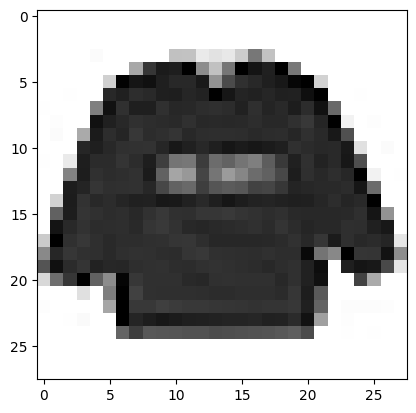

In [4]:
def get_image_arr(df, index):
    return df.iloc[index, :].to_numpy()

def plot_image(arr, x = 28, y = 28):
    img = arr.reshape(x, y)
    plt.imshow(img, cmap='gray_r', vmin=0, vmax=1)

plot_image(get_image_arr(df_px, 0))

An interesting way to visualize the dataset using the `plot_image` function is seeing what the average clothing item looks like. This shows that the dataset contains a lot of redundant data - corners are always white, and the middle is usually black.

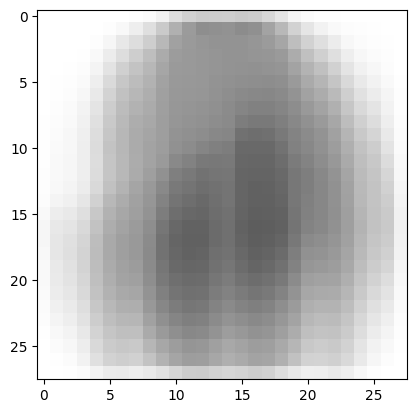

In [5]:
def plot_average_of(classes):
    plot_image(np.mean(df_px.loc[df['label'].isin(classes)].to_numpy(), axis=0))

plot_average_of([i for i in range(len(labels))])

## Dimensionality reduction

### PCA

Since the images contain a lot of redundant data, I have decided to use PCA as a first step in the dimensionality reduction process, since a lot of the principal components will be insignificant.

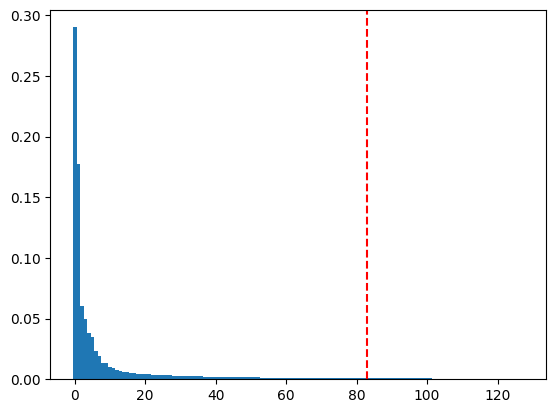

In [6]:
from sklearn.decomposition import PCA

pca = PCA(random_state=RS)
pca.fit(df_px)
scree_data = pca.explained_variance_ratio_

# 90% of the variance should remain
thresh = 0.9

sum = 0
idx = 0
for idx, el in enumerate(scree_data):
    sum += el
    if sum > thresh:
        break

scree_len = 128
plt.axvline(x=idx, color='red', linestyle='--', linewidth=1.5)
# plt.yscale('log')
plt.bar(range(scree_len), scree_data[:scree_len], width=1)
plt.show()

As expected, the scree plot (with the x axis clipped to 128 from the original 784, to improve readability) shows that the vast majority of principal components are insignificant. 

The red line on the scree plot represents the point to which I have decided to reduce the dimensionality, so that 90% of the variance remains. 

An interesting approach to visualising the components is plotting them as images (0 - white, 1 - black), to see the patterns that they represent. I found the component with index 1 to be particularly entertaining, since it looks like a pair of trousers. Components with higher indices are much more messy - component 32 only barely resembles the silhouette of a clothing item, whereas component 512 is an almost complete mess.

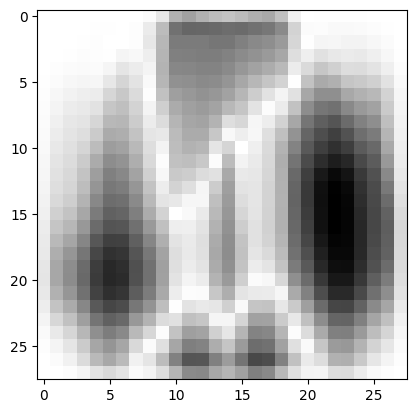

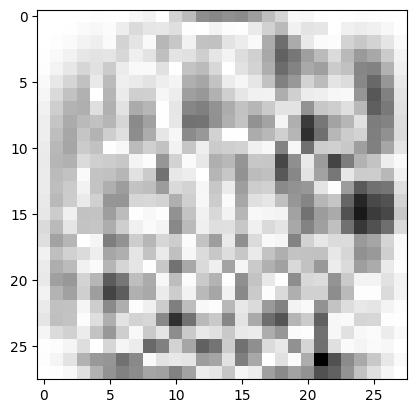

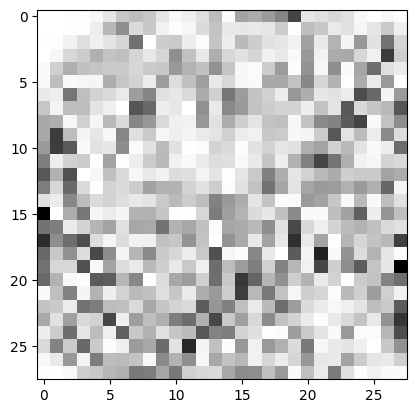

In [7]:
def plot_component(component_idx):
    def component_normalize(arr):
        return arr / np.max(arr)

    plot_image(component_normalize(np.abs(pca.components_[component_idx])))
    plt.show()

plot_component(1)
plot_component(32)
plot_component(512)

In [8]:
# Perform the reduction
n_components = idx + 1
pca = PCA(n_components=n_components, random_state=RS)
reduced_pca = pca.fit_transform(df_px)
print(f"Dimensionality reduced to: {n_components}")

Dimensionality reduced to: 84


### t-SNE

Next, to be able to visualise the dataset, I decided to apply some more advanced algorithms to the PCA-reduced dataset. The first of them I tried was t-SNE. It turned out, however, to be frustratingly slow, so in the experimental phase I used a random selection of 20% of the data.

In [9]:
from sklearn.manifold import TSNE

# df_pick_ratio = 0.1
df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

tsne = TSNE(n_components=2, random_state=RS)
reduced_tsne = tsne.fit_transform(reduced_pca[df_mask])

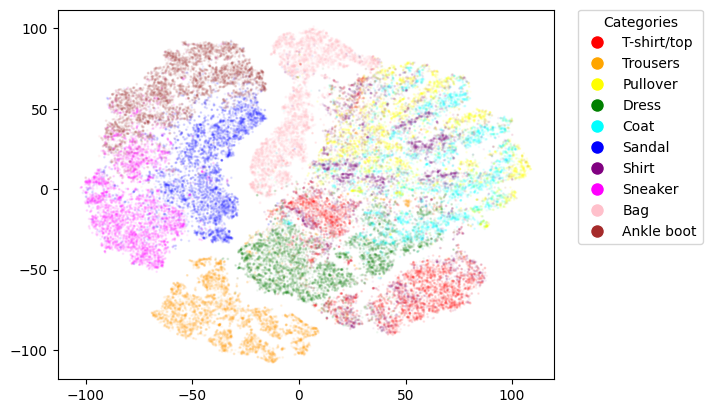

In [10]:
from matplotlib.colors import ListedColormap

def plot_2d(reduced, df_mask):
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown']
    cmap = ListedColormap(colors)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=l) for i, l in enumerate(labels)]
    
    # Add legend
    plt.legend(handles=legend_handles, title='Categories', loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0.)

    plt.scatter(reduced[:, 0], reduced[:, 1], c=df['label'][df_mask], cmap=cmap, s=1, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

plot_2d(reduced_tsne, df_mask)

t-SNE managed to separate some of the categories, but most of them remained jumbled together. Trousers and bags are very easy to distinguish, each in their own, well separated cluster. Sandals, ankle boots and sneakers are in three corners of one cluster. T-shirts/tops and dresses are somehow separated, but dresses are spread around T-shirts over two clusters. Pullovers, coats and shirts are a complete mess. 

With hopes of achieving better separation, I have decided to try out another algorithm, which I heard is faster and more efficient than t-SNE - UMAP.

### UMAP
UMAP did indeed prove to be much faster - so much faster in fact, that I was able to run it on the full dataset. I have settled on `n_neighbors = 16` and `min_dist = 0.1`, since they seemed to provide a good balance, making the clusters concentrated but at the same time not splitting them into too many smaller subclusters.

In [11]:
from umap import UMAP

df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(df_px), p=[df_pick_ratio, 1 - df_pick_ratio])

umap = UMAP(n_components=2, random_state=RS, n_neighbors=16, min_dist=0.1)
reduced_umap = umap.fit_transform(df_px[df_mask])

/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


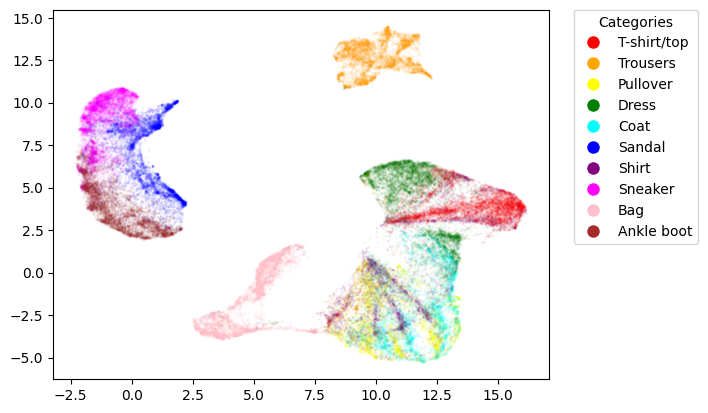

In [12]:
plot_2d(reduced_umap, df_mask)

The results produced by UMAP are quite a bit better than those produced by t-SNE. It managed to make the clusters denser, and separated the mess of upper attire categories somewhat better.

I conclude, that using those algorithms the dataset cannot be represented in 2d as well as e.g. the MNIST handwritten digit dataset. Clustering therefore needs to be performed in a higher dimensional space.

For visualisation purposes I will be using the UPAM result - the cluster separation is far clearer.

## Clustering

### KMeans
First, I decided to try the KMeans algorithm, since it is fast and easy to use, and good to use when we know how many clusters to expect - 10.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, ConfusionMatrixDisplay
from sklearn.metrics.cluster import contingency_matrix

df_mask_all = np.ones(len(df), dtype=bool)

kmeans = KMeans(n_clusters=10, random_state=RS)
# kmeans.fit(df_px) # 0.37; 4.7s
# kmeans.fit(reduced_pca) # 0.38; 0.7s
# kmeans.fit(reduced_tsne) # 0.33; 0.0s
kmeans.fit(reduced_umap) # 0.42; 0.0s

print(adjusted_rand_score(df['label'], kmeans.labels_))

0.4230780432504995


I found the results a little bit surprising, especially the fact that the 2d UMAP-reduced space produced the best results. Even then however, the adjusted rand score value isn't satisfactory. Let us now visualize our results.

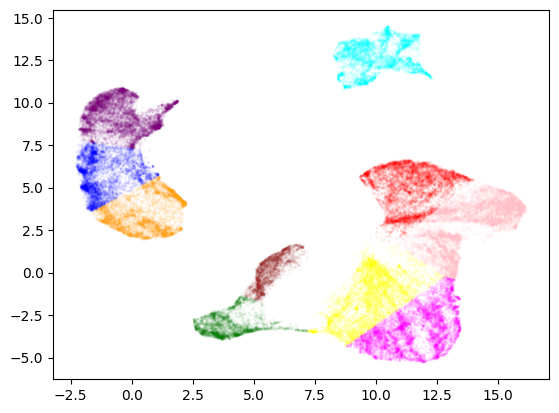

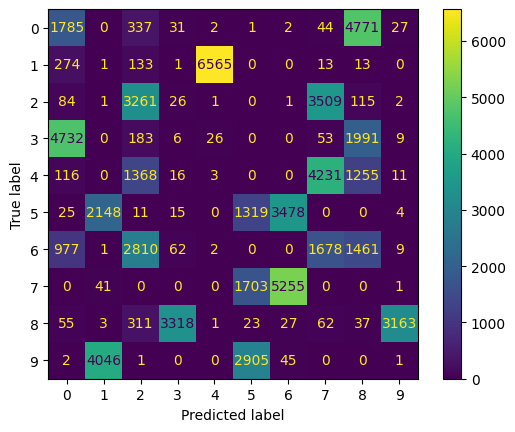

In [14]:
def plot_clusters(points, cluster_labels, df_mask):
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown']
    cmap = ListedColormap(colors)

    plt.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap=cmap, s=1, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

def plot_contingency_matrix(true_labels, predicted_labels):
    m = contingency_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(m)
    disp.plot()
    plt.show()

# plot_2d(reduced_umap, df_mask)
plot_clusters(reduced_umap, kmeans.labels_, df_mask_all)
plot_contingency_matrix(df['label'], kmeans.labels_)


Items with labels 1, 7, 9 (Trousers, Sneakers, Ankle boots) are clustered mostly correctly, but the algorithm had problems tracking the more complex shapes of remainig clusters. This is not surprising, since in the 2d space the clusters are far from spherical (which KMeans recognizes best).

Since the UMAP reduced dataset (even though it was only 2-dimensional) produced the best result, I decided to try and reduce the dimensionality with UMAP to some higher number, with hopes of achieving better results. This was also made possible by the fact that UMAP scales well even with higher target dimensionality.

In [15]:
umap_cluster = UMAP(n_components=32, n_neighbors=16, min_dist=0.1, random_state=RS)
reduced_umap_cluster = umap_cluster.fit_transform(df_px)

/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
kmeans.fit(reduced_umap_cluster) # 0.45; 0.0s

print(adjusted_rand_score(df['label'], kmeans.labels_))

0.49069263323545953


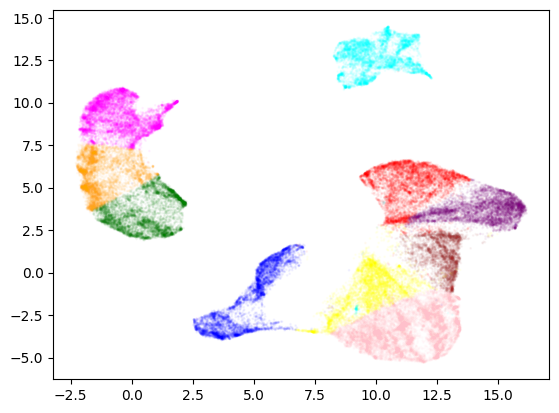

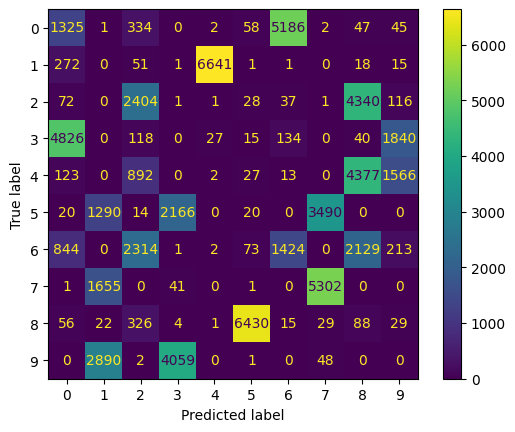

In [17]:
plot_clusters(reduced_umap, kmeans.labels_, df_mask_all)
plot_contingency_matrix(df['label'], kmeans.labels_)

The results look a bit better than those achieved before. The shoes are separated more accurately, and T-shirts/tops have also been detected as a similar cluster.

I tried running the clustering with different target UMAP dimensionalities (16, 32, 64, 128). Each time I got a very similar adjusted rand score (between 0.45 and 0.51). The larger the dimensionality, however, the longer both the UMAP reduction and KMeans clustering took. I settled on 32, since it provided the best balance between performance and efficacy. 

Still, an adjuster rand score of 0.5 isn't really satisfactory. This might be due to the fact, that KMeans is good at detecting spherical clusters, whereas our clusters (at least in the 2d space) don't look particularily spherical. I therefore proceeded to more advanced clustering methods.

### DBSCAN
I decided to first try density-based clusterings - the UMAP-reduced dataset in 2d looked like a lot of the clusters are distinguishable as areas of increased density, and so I concluded that the 32d reduced set I will be working on may exhibit similar properties. First of those algorithms was DBSCAN. A lot of parameter tweaking was needed to achieve at least partially satisfactory results. Also, since I couldn't pass the target amount of clusters as a parameter, it required quite some trial and error to procude the desired 10 clusters.

In [43]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.52, min_samples=330)
dbscan.fit(reduced_umap_cluster) # 0.46; 3.6s

print(np.unique(dbscan.labels_))

print(adjusted_rand_score(df['label'], dbscan.labels_))
print(f"Noise ratio: {(dbscan.labels_ == -1).sum() / len(dbscan.labels_)}")

[-1]
0.0
Noise ratio: 1.0


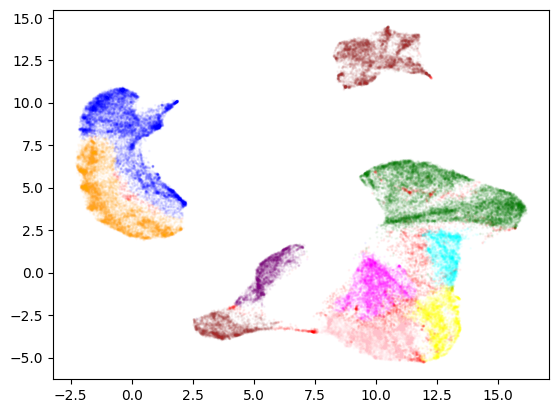

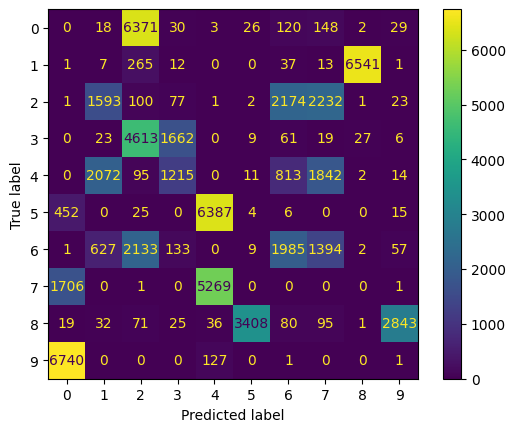

In [42]:
plot_clusters(reduced_umap[df_mask_all], dbscan.labels_, df_mask_all)
plot_contingency_matrix(df['label'][dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])

Visually, the results look slightly different than those from KMeans, the clusters shapes are much more elaborate. The numbers however aren't that appealing - I couldn't get the adjusted rand score to exceed the one generated by KMeans.

Next, I decided to take a look at the overview of clustering methods from the [scikit-learn website](https://scikit-learn.org/1.5/modules/clustering.html#overview-of-clustering-methods). As my next candidate, I chose spectral clustering - it seemed to be able to deal with the shapes of data that I imagined the dataset to be. It also allowed me to specify the desired number of clusters. The algorithm was however very slow, and I had to reduce my sample size to 10% to be able to experiment with it efficiently.

In [54]:
from sklearn.cluster import SpectralClustering

df_pick_ratio = 0.1
df_mask_sc = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

sc = SpectralClustering(n_clusters=10, random_state=RS, n_neighbors=256)
sc.fit(reduced_umap_cluster[df_mask_sc])
# sc.fit(reduced_umap[df_mask_sc])

print(adjusted_rand_score(df['label'][df_mask_sc], sc.labels_))

0.4895354651855809


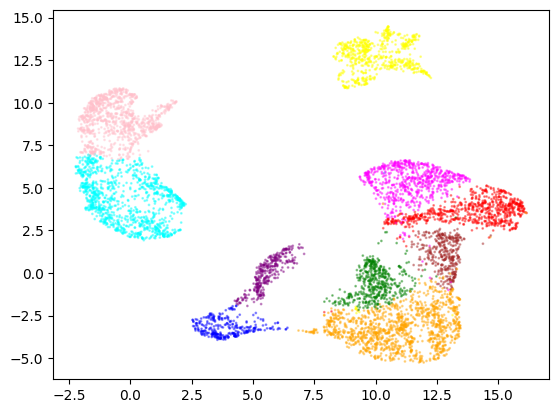

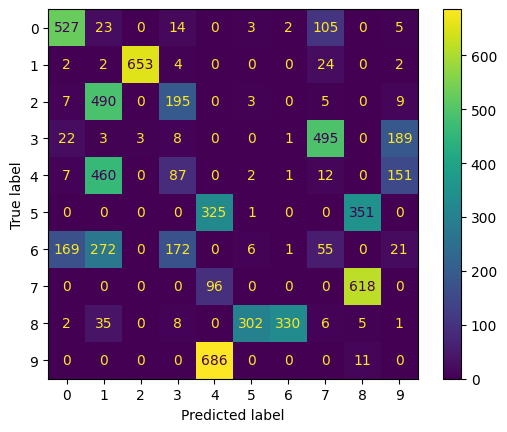

In [55]:
plot_clusters(reduced_umap[df_mask_sc], sc.labels_, df_mask_sc)
plot_contingency_matrix(df['label'][df_mask_sc], sc.labels_)

Again, I didn't manage to achieve better results than those provided by KMeans.

### Agglomerative clustering
For completeness, I decided to try the hierarchical approach to clustering, provided by agglomerative clustering.

In [99]:
from sklearn.cluster import AgglomerativeClustering

df_pick_ratio = 0.25
df_mask_ac = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

ac = AgglomerativeClustering(n_clusters=10, linkage='average', metric='manhattan')
ac.fit(reduced_umap_cluster[df_mask_ac])

print(adjusted_rand_score(df['label'][df_mask_ac], ac.labels_))

0.46691318802023246


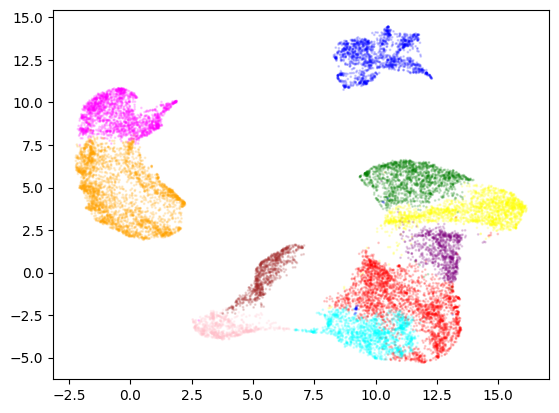

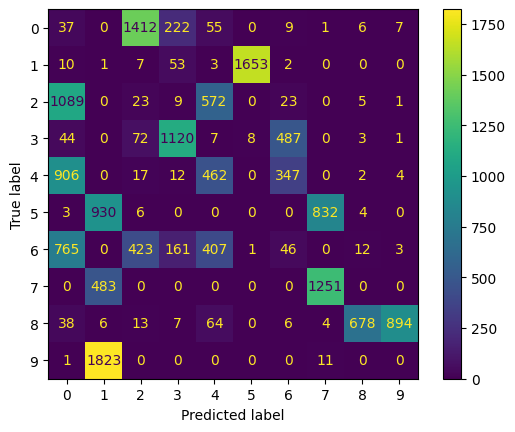

In [100]:
plot_clusters(reduced_umap[df_mask_ac], ac.labels_, df_mask_ac)
plot_contingency_matrix(df['label'][df_mask_ac], ac.labels_)

The results are again very similar. From our attempts to cluster the data we can draw the conclusion, that it is too complex to be reliably clustered.

## Classification
The task of splitting the dataset into training and testing has already been done for us by Kaggle. I will therefore refrain from doing this myself.

In [125]:
X_train, X_test, y_train, y_test = df_train_px, df_test_px, df_train['label'], df_test['label']

### K nearest neighbors

The first classifier I decided to try was the K nearest neighbors classifier, since it is simple and fast. 

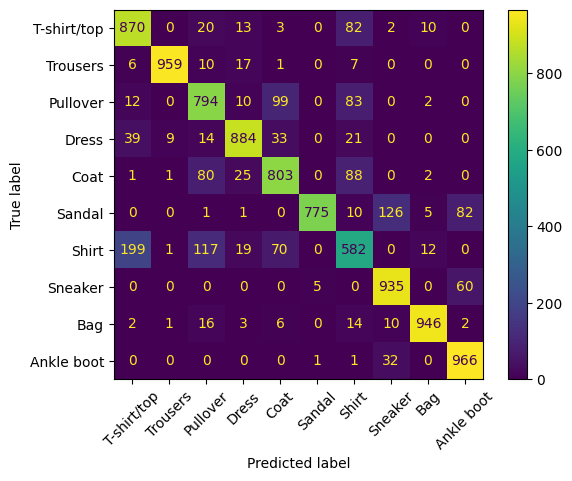

              precision    recall  f1-score   support

 T-shirt/top       0.77      0.87      0.82      1000
    Trousers       0.99      0.96      0.97      1000
    Pullover       0.75      0.79      0.77      1000
       Dress       0.91      0.88      0.90      1000
        Coat       0.79      0.80      0.80      1000
      Sandal       0.99      0.78      0.87      1000
       Shirt       0.66      0.58      0.62      1000
     Sneaker       0.85      0.94      0.89      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.87      0.97      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

m = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(m, display_labels=[l for l in labels])
disp.plot(xticks_rotation=45)
plt.show()
print(classification_report(y_test, predictions, target_names=[l for l in labels]))

We can immediately see that classification is an easier task than clustering - even with this simple algorithm, we achieved an accuracy of 85%. Looking at the confusion matrix, we can also appreciate that the results are also visibly better. There is still however some confusion among the upper garments - shirts for instance are often mistaken for T-shirts/tops or pullovers. I decided to try out some other algorithms, with hopes that they might in some way be able to distinguish this group of clothing better.

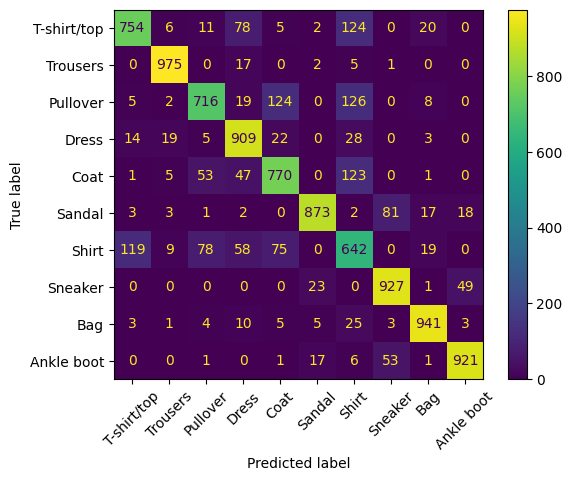

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.75      0.79      1000
    Trousers       0.96      0.97      0.97      1000
    Pullover       0.82      0.72      0.77      1000
       Dress       0.80      0.91      0.85      1000
        Coat       0.77      0.77      0.77      1000
      Sandal       0.95      0.87      0.91      1000
       Shirt       0.59      0.64      0.62      1000
     Sneaker       0.87      0.93      0.90      1000
         Bag       0.93      0.94      0.94      1000
  Ankle boot       0.93      0.92      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [136]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=RS)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

m = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(m, display_labels=[l for l in labels])
disp.plot(xticks_rotation=45)
plt.show()
print(classification_report(y_test, predictions, target_names=[l for l in labels]))

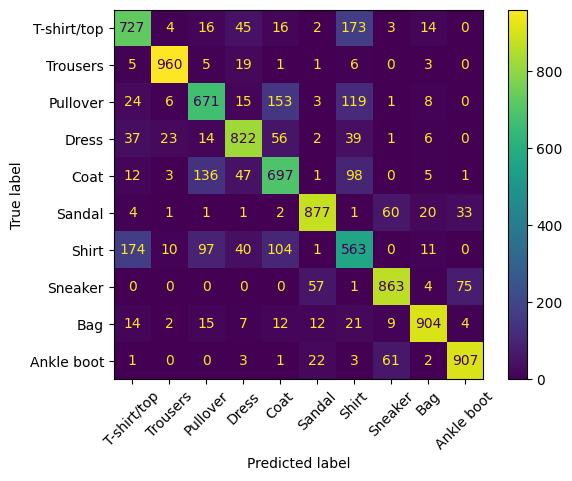

              precision    recall  f1-score   support

 T-shirt/top       0.73      0.73      0.73      1000
    Trousers       0.95      0.96      0.96      1000
    Pullover       0.70      0.67      0.69      1000
       Dress       0.82      0.82      0.82      1000
        Coat       0.67      0.70      0.68      1000
      Sandal       0.90      0.88      0.89      1000
       Shirt       0.55      0.56      0.56      1000
     Sneaker       0.86      0.86      0.86      1000
         Bag       0.93      0.90      0.91      1000
  Ankle boot       0.89      0.91      0.90      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [137]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=32)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

m = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(m, display_labels=[l for l in labels])
disp.plot(xticks_rotation=45)
plt.show()
print(classification_report(y_test, predictions, target_names=[l for l in labels]))

## ChatGPT
What follows is the approach to the problem proposed by ChatGPT model 4o, with some notes provided by me to compare its approach to mine.

### Response with summary of the approach
> Dimensionality Reduction:
> - Use PCA to reduce the dimensionality of the dataset to 50 components.
> - Apply t-SNE for further dimensionality reduction to 2D for visualization.
> Visualization:
> - Plot the 2D data from t-SNE, coloring points by their labels (classes).
> Clustering:
> - Apply k-means clustering to the PCA-reduced data.
> - Evaluate clusters using metrics like silhouette score and adjusted Rand index.
> Classification:
> - Split the data into training and test sets.
> - Train a classifier (e.g., random forest or logistic regression) on the PCA-reduced data.
> - Evaluate the model using accuracy and classification metrics like precision, recall, and F1-score.

### Code provided in the response
I had to modify the code a little bit, to make it compatible with my way of importing the data

In [139]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train = df_train_px
X_test = df_test_px

y_train = df_train['label']
y_test = df_test['label']

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

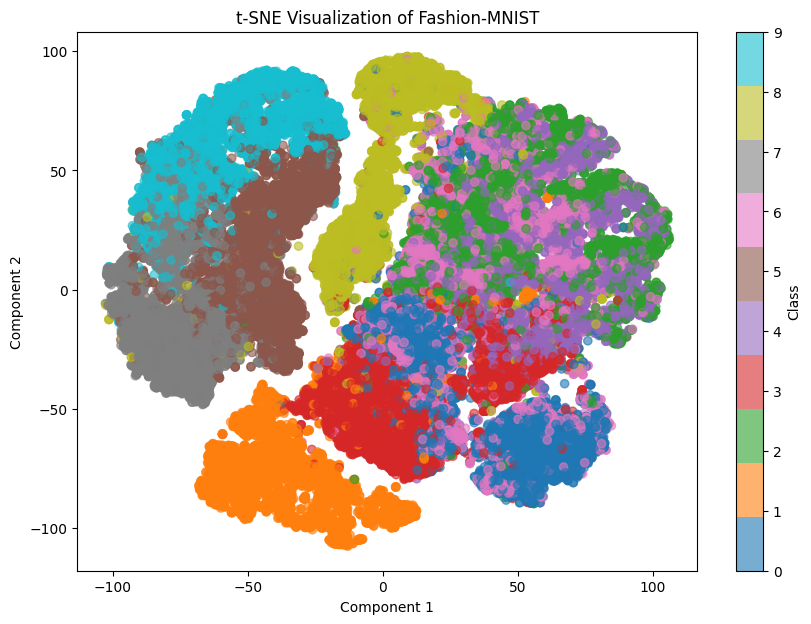

In [140]:

# Dimensionality Reduction with PCA (50 components)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Further Dimensionality Reduction with t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)

# Visualize the 2D t-SNE data
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.title("t-SNE Visualization of Fashion-MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

The approach to dimensionality reduction proposed by ChatGPT was quite similar to my initial attempts. It first started with PCA, which was the same thing I did. The difference was, that I calculated the desired number of components to retain 90% of the variance, and ChatGPT just picked 50.

The results achieved with the t-SNE reduction look very similar to mine.

One obvious difference in our approaches is, of course, that ChatGPT didn't decide to try out UMAP. 

In [ ]:
# Clustering with K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_train_pca)

# Evaluate Clustering
sil_score = silhouette_score(X_train_pca, clusters)
rand_index = adjusted_rand_score(y_train, clusters)
print(f"Silhouette Score: {sil_score:.2f}")
print(f"Adjusted Rand Index: {rand_index:.2f}")

Silhouette Score: 0.17
Adjusted Rand Index: 0.37


For clustering, ChatGPT decided to only use KMeans. The KMeans results are also similar to those that I achieved with my PCA reduced dataset. I managed to get a higher adjusted rand index by using the UMAP reduced dataset for clustering, as well as with all the other algorithms that I have tried.

ChatGPT also used another method for evaluating clustering, which I haven't used - the silhouette score.

In [143]:
# Classification using Random Forest
# Split data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_split, y_train_split)

# Evaluate classifier
y_pred = clf.predict(X_val_split)
report = classification_report(y_val_split, y_pred, target_names=[f"Class {i}" for i in range(10)])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.85      0.82      1232
     Class 1       0.99      0.96      0.97      1174
     Class 2       0.78      0.81      0.80      1200
     Class 3       0.85      0.90      0.88      1242
     Class 4       0.77      0.80      0.78      1185
     Class 5       0.91      0.93      0.92      1141
     Class 6       0.70      0.57      0.63      1243
     Class 7       0.92      0.91      0.92      1224
     Class 8       0.95      0.96      0.95      1149
     Class 9       0.94      0.94      0.94      1210

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



As for classification, ChatGPT used an algorithm I didn't consider - RandomForestClassifier. The results of using the algorithm are very similar to those that I achieved with the algoritms I have used.